In [5]:
import import_src
from src.order_broker import Broker
from src.broker_vis import *
from src.models import *
import numpy as np
import random
import pandas as pd

In [6]:
# Create a broker, and a market for ACME stock
asset = "ACME"
broker = Broker()
broker.create_market(asset)

In [7]:
num_traders = 16
starting_cash_balance_cents = 3200
starting_asset_balance = 100

initial_cash_in_market = num_traders * starting_cash_balance_cents
initial_assets_in_market = num_traders * starting_asset_balance

# create accounts all traders
# give each of them 10000 cents of cash, and 100 shares of ACME stock
traderIds = [i for i in range(num_traders)]
for traderId in traderIds:
    broker.open_account(traderId)
    broker.deposit_cash(traderId, starting_cash_balance_cents)
    broker.deposit_asset(traderId, starting_asset_balance, asset)

# print trader ids
print("Trader IDs:", [traderId for traderId in broker.accounts.keys()])


Trader IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
# simulate market activity by having each trader make random trades
# monkeys on a bloomberg terminal
num_iterations = 100
prefered_bid_price = 32
bid_price_std = 4
prefered_ask_price = 32
ask_price_std = 4
order_size_k = 1

# Adding a bias towards market orders reduces assets and cash tied up in unmatched limit orders
# it also seems to reduce the number of bids that are greater than asks
limit_fraction: float = 0.5
bid_fraction: float = 0.5

# record level 1 order history
l1_hist_dict: dict[str, list] = {
    "best_bid" : [], 
    "best_ask" : [], 
    "timestamp" : []
}


timestamp = 0
# each trader makes 1 trade per iteration
for i in range(num_iterations):

    # shuffle to remove bias from the order of the list
    # prevents "first mover advantage"
    random.shuffle(traderIds)
    for traderId in traderIds:     
        # construct order
        orderId:int = random.randint(1, 2**30)
        side: Side
        type: OrderType
        priceCents: int = 0
        amount: int = np.random.poisson(order_size_k)
        if random.random() < bid_fraction: # Buy
            side = Side.BUY
            priceCents = int(np.random.normal(prefered_bid_price, bid_price_std))
        else: # Sell
            priceCents = int(np.random.normal(prefered_ask_price, ask_price_std))
            side = Side.SELL
        if random.random() < limit_fraction: # Limit
            type = OrderType.LIMIT
        else: # Market
            type = OrderType.MARKET
            priceCents = 0 # price is ignored for market orders
        order = Order(
            id=orderId,
            traderId=traderId,
            side=side,
            type=type,
            priceCents=priceCents,
            amount=amount,
            timestamp=timestamp
        )
        timestamp += 1
        
        # place order
        broker.place_order(asset, order)

        # append to L1 history
        best_bid = broker.get_highest_bid(asset)
        best_ask = broker.get_lowest_ask(asset)
        l1_hist_dict["timestamp"].append(timestamp)
        l1_hist_dict["best_ask"].append(best_ask)
        l1_hist_dict["best_bid"].append(best_bid)

l1_hist = pd.DataFrame(l1_hist_dict)



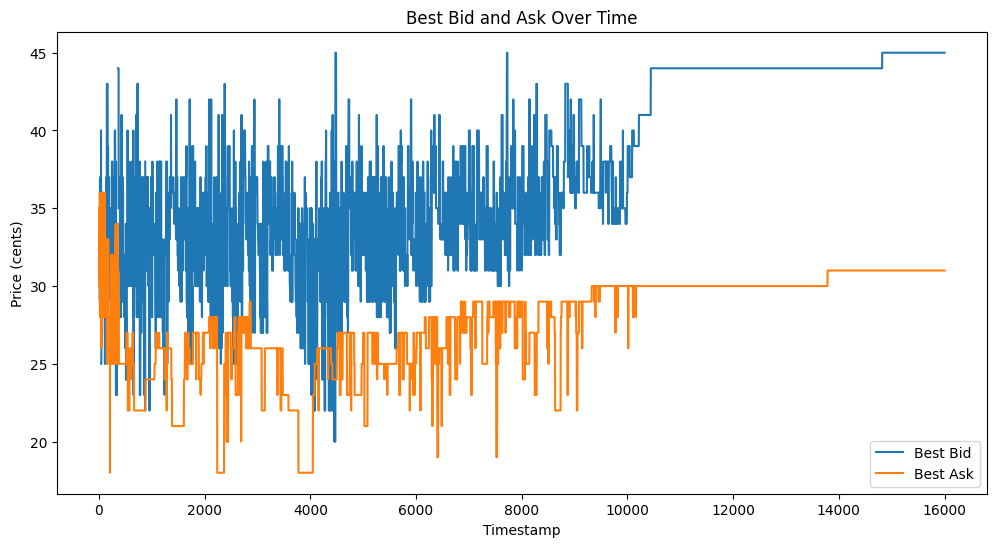

In [9]:
# plot best bid and ask over time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(l1_hist['timestamp'], l1_hist['best_bid'], label='Best Bid')
ax.plot(l1_hist['timestamp'], l1_hist['best_ask'], label='Best Ask')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price (cents)')
ax.set_title('Best Bid and Ask Over Time')
ax.legend()
plt.show()

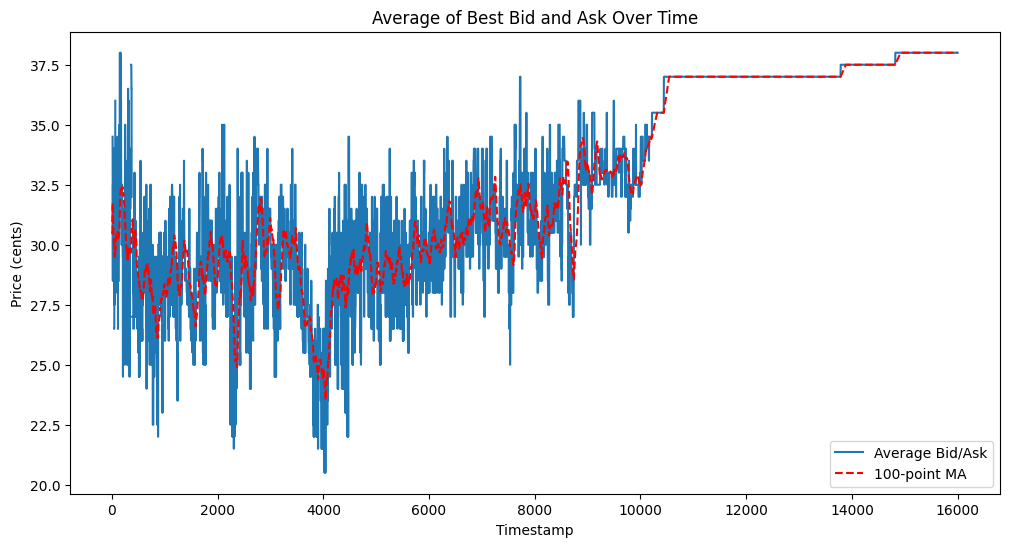

In [10]:
# plot average of best bid and ask over time with moving average
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# compute average, None if either bid or ask is missing
avg_series = l1_hist.apply(
    lambda row: (row["best_bid"] + row["best_ask"]) / 2
                if pd.notna(row["best_bid"]) and pd.notna(row["best_ask"])
                else None,
    axis=1
)

# convert None to np.nan so matplotlib skips those segments
avg_plot = avg_series.astype(float)

# compute moving average
ma_window = 100  # number of points in moving average window
ma_plot = pd.Series(avg_plot).rolling(window=ma_window, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(l1_hist["timestamp"], avg_plot, label="Average Bid/Ask")
ax.plot(l1_hist["timestamp"], ma_plot,
        label=f"{ma_window}-point MA",
        color="red", linestyle="--")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Price (cents)")
ax.set_title("Average of Best Bid and Ask Over Time")
ax.legend()
plt.show()

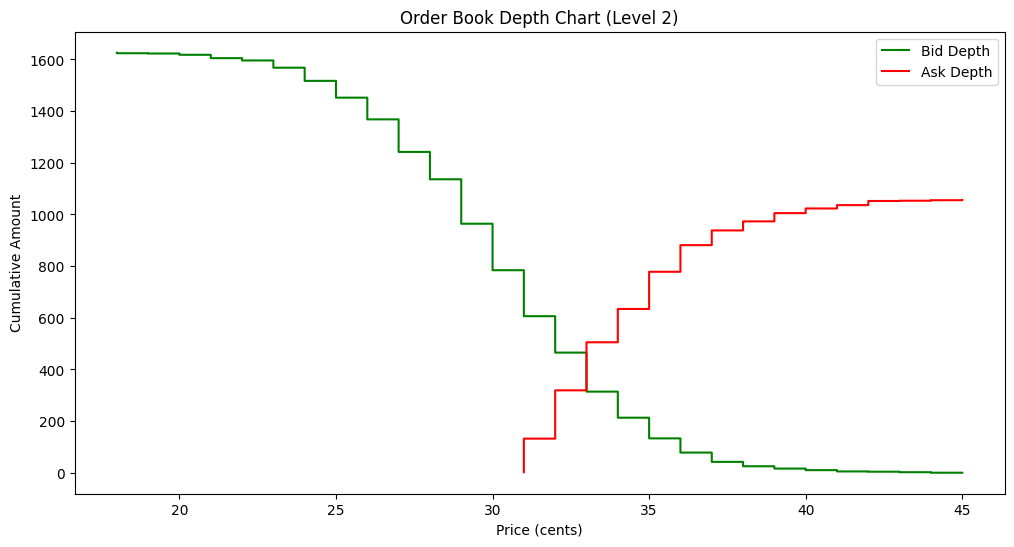

In [11]:
depth_chart(broker, asset)

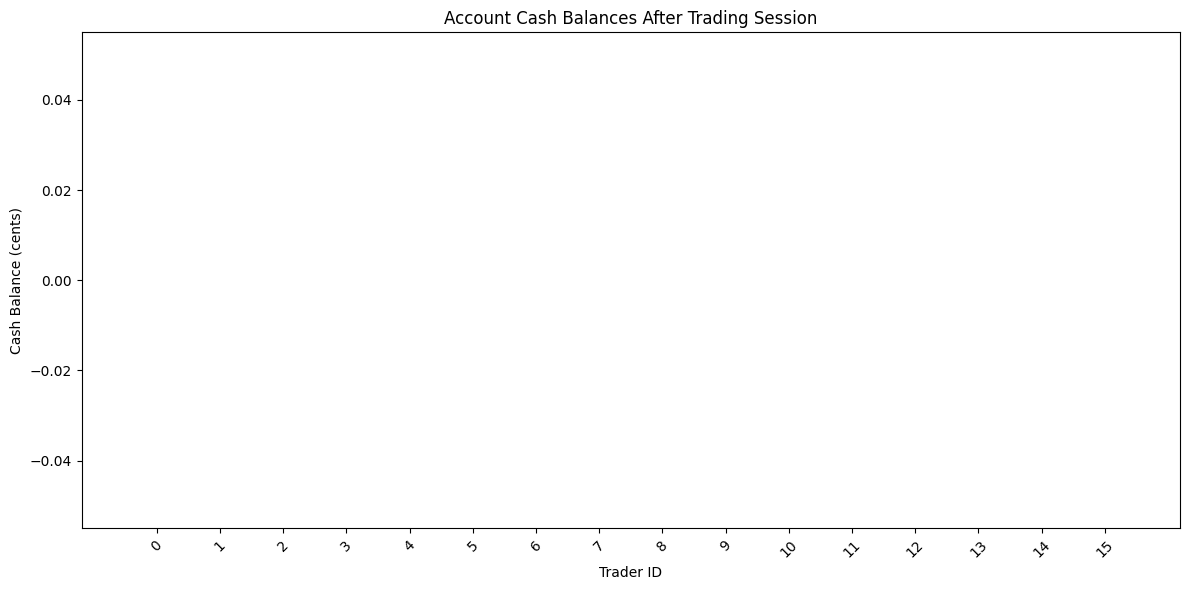

In [12]:
show_account_cash_balances(broker)

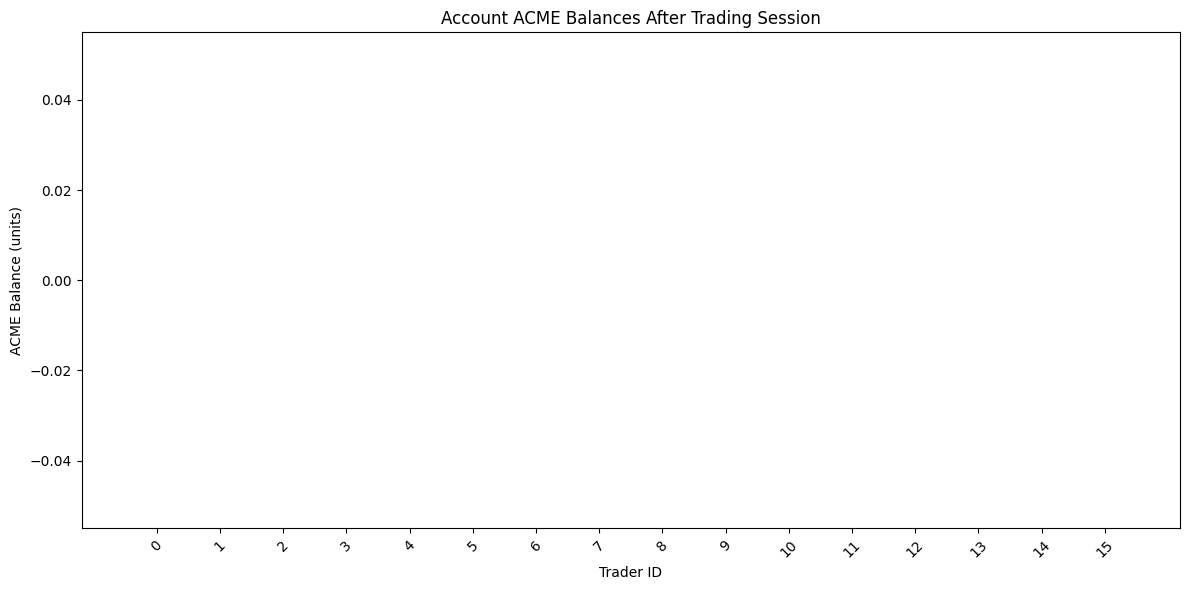

In [13]:
show_account_asset_balances(broker, asset)

In [14]:
# spearmn rank correlation between cash balance and ACME stock
from scipy.stats import spearmanr
cash_balances = []
asset_balances = []
for traderId in traderIds:
    cash_balances.append(broker.get_account_info(traderId).cashBalanceCents)
    asset_balances.append(broker.get_account_info(traderId).portfolio[asset])

corr, _ = spearmanr(cash_balances, asset_balances)
print(f"Spearman rank correlation between cash and {asset} balances: {corr}")

Spearman rank correlation between cash and ACME balances: nan


/var/folders/sq/y_3v3tcs36179m6pk2tldqxw0000gn/T/ipykernel_83277/1561759775.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(cash_balances, asset_balances)


In [15]:
# compare total cash and assets in market to final balances.
# Cash and assets are neither created nor destroyed in this simulation,
# they are only transferred between traders and the broker.
total_trader_cash = sum([broker.get_account_info(tid).tradable_balance_cents() for tid in traderIds])
total_trader_assets = sum([broker.get_account_info(tid).tradable_asset_amount(asset) for tid in traderIds])

total_broker_cash = broker.total_cash_held_in_bid_limits(asset)
total_broker_assets = broker.total_assets_held_in_ask_limits(asset)

final_total_cash = total_trader_cash + total_broker_cash
final_total_assets = total_trader_assets + total_broker_assets

print(f"Initial total cash in market: {initial_cash_in_market} cents")
print(f"Final total cash in market: {final_total_cash} cents")
print(f"Initial total {asset} assets in market: {initial_assets_in_market}")
print(f"Final total {asset} assets in market: {final_total_assets}")

assert final_total_cash == initial_cash_in_market, "Total cash in market does not match initial amount!"
assert final_total_assets == initial_assets_in_market, "Total assets in market does not match initial amount!"
                                                                                  



Initial total cash in market: 51200 cents
Final total cash in market: 0 cents
Initial total ACME assets in market: 1600
Final total ACME assets in market: 0


AssertionError: Total cash in market does not match initial amount!

In [ ]:
# TODO https://quant.stackexchange.com/questions/2820/has-spectrum-analysis-ever-been-used-successfully-to-analyse-historical-price-da